In [11]:
import chess
import chess.engine
import random
import numpy as np

In [12]:
# creates a random board instance
def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(0, max_depth);

    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break
    return board

def stockfish(board, depth):
    with chess.engine.SimpleEngine.popen_uci('\content\stockfish') as sf:
        result = sf.analyse(board,chess.engine.Limit(depth=depth))
        score = result['score'].white().score()
        return score

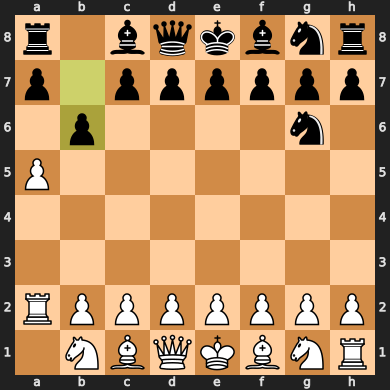

In [13]:
board = random_board(10)
board




# Create the Database
First, we create a usefull onehot encoding board representation (14 x 8 x 8)

In [14]:
# dict, transform str to int
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}
#
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board):
  # this is the 3d matrix representing the board
  board3d = np.zeros((14, 8, 8), dtype=np.int8)

  # add pieces view on the matrix
  for piece in chess.PIECE_TYPES:
      for square in board.pieces(piece, chess.WHITE):
          idx = np.unravel_index(square, (8,8))
          board3d[piece - 1,7-idx[0],idx[1]] = 1
      for square in board.pieces(piece, chess.BLACK):
          idx = np.unravel_index(square, (8, 8))
          board3d[piece + 5][7 - idx[0]][idx[1]] = 1
  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [15]:
split_dims(board)



array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

Now, all we have to do is call random_board() to create random boards, stockfish() to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using split_dims(), now creating the dataset is easy!

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers



def build_model(conv_size, conv_depth):
  model = keras.Sequential()
  model.add(layers.Input(shape=(14,8,8)))

  # adding the convolutional layers
  for _ in range(conv_depth):
    model.add(layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu', data_format='channels_first'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

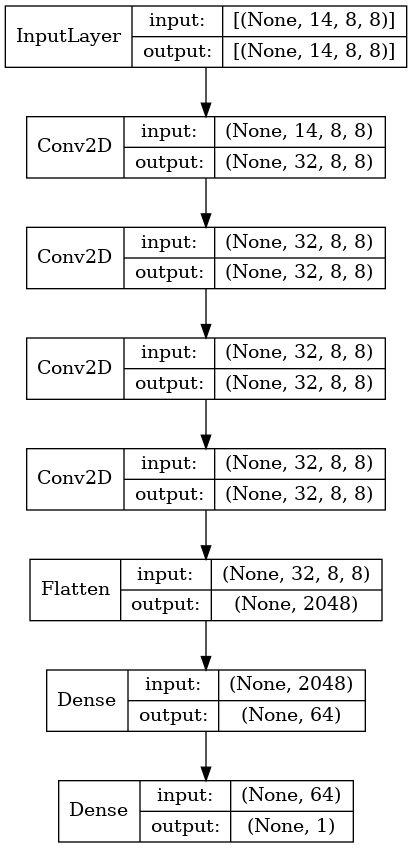

In [17]:
model = build_model(32, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Resnet

In [18]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Train network

In [19]:
import tensorflow.keras.callbacks as callbacks


def get_dataset():
	container = np.load('dataset.npz')
	b, v = container['b'], container['v']
	v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


Train the model

In [ ]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model.save('model.h5')
